In [1]:
import numpy as np
import cv2
import os
import glob
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import tree
from sklearn import metrics
from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage.filters import gabor
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import preprocessing as p
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import random

### add black background and convert every pictures to same size without changing appearance

In [2]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[:2]
    blank_image = np.zeros((900,900,3), np.uint8)
    blank_image[:,:] = (255,255,255)
    l_img = blank_image.copy()     
    x_offset = 100
    y_offset = 100
    l_img[y_offset:y_offset+height, x_offset:x_offset+width] = img.copy()
    lower_range = (70, 0, 0)
    upper_range = (255, 255, 120) 
    mask = cv2.inRange(l_img, lower_range, upper_range)
    img = cv2.bitwise_and(l_img, l_img, mask=mask)
    return img,height,width

### get lines of saffron , using this for smoothness

In [3]:
def get_lines(gray_image):
    edge = cv2.Canny(gray_image, 50, 200, None, 3)
    lines = cv2.HoughLinesP(
    edge, 
    rho=1, 
    theta=np.pi / 180, 
    threshold=10, 
    minLineLength=10,    
    maxLineGap=10
)
    return lines

### Measuring the destiny of the angles of the lines

In [4]:
def get_destiny(lines):
    angles = []
    sum=0
    degs = np.zeros(5)   
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi  
        angles.append(angle)
    for angel in angles:
        angel += 90
        angel = angel // 45
        angel = int (angel)
        degs[angel] = 1
    for i in range(5):
        sum+=degs[i]
    
    return sum  

### using this to measuring the smoothness of saffron

In [5]:
def get_khami(lines):
    sum=0;
    for line1 in lines:
        for line2 in lines:
            x11, y11, x12, y12 = line1[0]
            x21, y21, x22, y22 = line2[0]
            ang1 = (np.arctan2(y12 - y11, x12 - x11) * 180.0 / np.pi)
            ang2 = (np.arctan2(y22 - y21, x22 - x21) * 180.0 / np.pi)
            diff = min ( abs(ang1 - ang2) , 180 - abs(ang1 - ang2) )
            sum += (diff)
    return (sum/2 )/(len(lines) * len(lines))

### counting number of yellow pixels in saffron pictures

In [6]:
def yellow_mask(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_range = (0, 150, 200) 
    upper_range = (105, 255, 255) 
    mask = cv2.inRange(img, lower_range, upper_range)
    color_img = cv2.bitwise_and(img, img, mask=mask)
    return np.count_nonzero(color_img)

### skeletonize binary image

In [7]:
def skeletonize(binary_image):
    size = np.size(binary_image)
    skel = np.zeros(binary_image.shape, np.uint8)

    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False

    while not done:
        eroded = cv2.erode(binary_image, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(binary_image, temp)
        skel = cv2.bitwise_or(skel, temp)
        binary_image = eroded.copy()

        zeros = size - cv2.countNonZero(binary_image)
        done = zeros == size

    return skel

### using this to measurement of branching

In [8]:
def detect_branch_points(skeleton,heigth,width):
        sum=0
        for i in range(100,100+heigth):   
            for j in range(100,100+width):
                if(skeleton[i,j]==0):
                    column = skeleton[:, j]
                    row = skeleton[i, :]
                    rights = np.count_nonzero(row[:j] > 200)
                    lefts = np.count_nonzero(row[j:] > 200)
                    ups = np.count_nonzero(column[:i] > 200)
                    downs = np.count_nonzero(column[i:] > 200)
                    if(rights * lefts  > 0):
                        sum += 1
                    if(ups * downs > 0):
                        sum += 1
        return sum

### using this to measurement of branching

In [9]:
def detect_branch_points2(skeleton,heigth,width):
        sum=0
        for i in range(100,100+heigth):   
            for j in range(100,100+width):
                if(skeleton[i,j]==0):
                    column = skeleton[:, j]
                    row = skeleton[i, :]
                    rights = np.count_nonzero(row[:j] > 200)
                    lefts = np.count_nonzero(row[j:] > 200)
                    ups = np.count_nonzero(column[:i] > 200)
                    downs = np.count_nonzero(column[i:] > 200)
                    if(rights * lefts * ups * downs > 0):
                        sum+=1
        return sum

### best model to classify to 'neging' and 'not_negin'

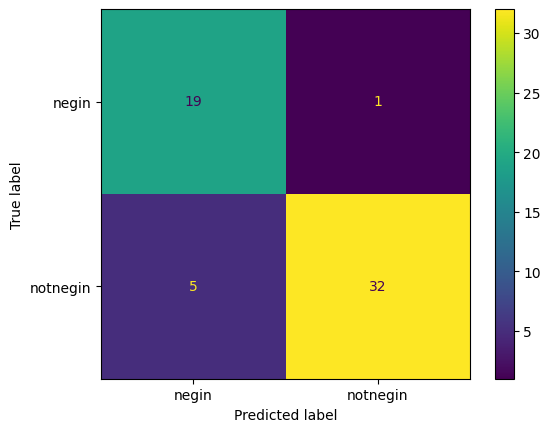

Accuracy: 0.8947368421052632


In [12]:
train_path  = "Desktop/negin_train"
train_names = os.listdir(train_path)
train_pics = []
train_labels   = []
train_features = []
plot2 = []
for train_name in train_names:
   cur_path = train_path + "/" + train_name
   cur_label = train_name
   for file in glob.glob(cur_path + "/*.jpg"):
       img = cv2.imread(file)  
 
       img,heigth,width = preprocess(img) 
       yellow_pixels = yellow_mask(img)  
       gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                         
       _, binary_image = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
       skeleton = skeletonize(binary_image)
       length = cv2.countNonZero(skeleton) 
       branch_points = detect_branch_points(skeleton,heigth,width) 
       branch_points2 = detect_branch_points2(skeleton,heigth,width) 
       lines = get_lines(skeleton)
       destiny = get_destiny(lines)     
       khami = get_khami(lines) 
       feature = [branch_points2,yellow_pixels]  
       train_features.append( feature ) 
       train_labels.append(cur_label) 
        
arr = np.array(train_features)
min_max_scaler = p.MinMaxScaler()
train_features = min_max_scaler.fit_transform(arr)

test_features = []
test_pics = []
test_labels = []
test_pr = []

test_path = ("Desktop/negin_test")
test_names = os.listdir(test_path)
for test_name in test_names:
   cur_path = test_path + "/" + test_name
   cur_label = test_name
   for file in glob.glob(cur_path + "/*.jpg"):
       img = cv2.imread(file) 
  
       img,heigth,width = preprocess(img) 
       yellow_pixels = yellow_mask(img)  
       gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       _, binary_image = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
       skeleton = skeletonize(binary_image)
       length = cv2.countNonZero(skeleton) 
       branch_points = detect_branch_points(skeleton,heigth,width) 
       branch_points2 = detect_branch_points2(skeleton,heigth,width) 
       lines = get_lines(skeleton)
       destiny = get_destiny(lines)     
       feature = [branch_points2,yellow_pixels]   
       test_features.append( feature ) 
       test_labels.append(cur_label)  
    
arr = np.array(test_features)
min_max_scaler = p.MinMaxScaler()
test_features = min_max_scaler.fit_transform(arr)


model = SVC(C=100, kernel='rbf')
model.fit(train_features, train_labels)
prediction = model.predict(test_features)
confusion_matrix = metrics.confusion_matrix(test_labels, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['negin','notnegin'])
cm_display.plot()
plt.show()
print("Accuracy:",metrics.accuracy_score(test_labels, prediction))

### best model to classify to 'negal' and 'not_negal'

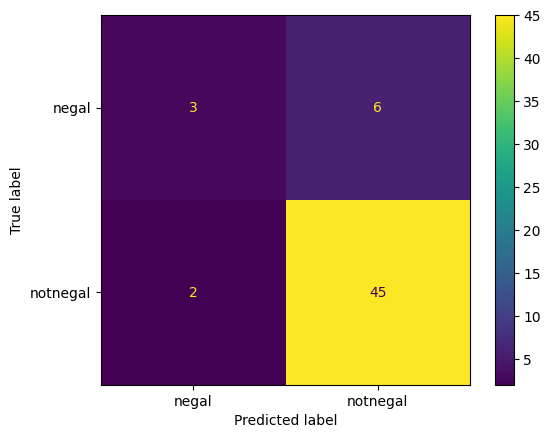

Accuracy: 0.8571428571428571


In [25]:
train_path  = "Desktop/negal_train"
train_names = os.listdir(train_path)
train_pics = []
train_labels   = []
train_features = []
plot2 = []
for train_name in train_names:
   cur_path = train_path + "/" + train_name
   cur_label = train_name
   for file in glob.glob(cur_path + "/*.jpg"):
       img = cv2.imread(file)  
       csc = calculate_stigma_count(img)  
       img,heigth,width = preprocess(img) 
       yellow_pixels = yellow_mask(img)  
       gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                         
       _, binary_image = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
       skeleton = skeletonize(binary_image)
       length = cv2.countNonZero(skeleton) 
       branch_points = detect_branch_points(skeleton,heigth,width) 
       branch_points2 = detect_branch_points2(skeleton,heigth,width) 
       lines = get_lines(skeleton)
       destiny = get_destiny(lines)     
       khami = get_khami(lines) 
       feature = [branch_points2,yellow_pixels]
       train_features.append( feature ) 
       train_labels.append(cur_label) 
        
arr = np.array(train_features)
min_max_scaler = p.MinMaxScaler()
train_features = min_max_scaler.fit_transform(arr)

test_features = []
test_pics = []
test_labels = []
test_pr = []

test_path = ("Desktop/negal_test")
test_names = os.listdir(test_path)
for test_name in test_names:
   cur_path = test_path + "/" + test_name
   cur_label = test_name
   for file in glob.glob(cur_path + "/*.jpg"):
       img = cv2.imread(file) 
       csc = calculate_stigma_count(img)   
       img,heigth,width = preprocess(img) 
       yellow_pixels = yellow_mask(img)  
       gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       _, binary_image = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
       skeleton = skeletonize(binary_image)
       length = cv2.countNonZero(skeleton) 
       branch_points = detect_branch_points(skeleton,heigth,width) 
       branch_points2 = detect_branch_points2(skeleton,heigth,width) 
       lines = get_lines(skeleton)
       destiny = get_destiny(lines)     
       khami = get_khami(lines)
       feature = [branch_points2,yellow_pixels] 
       test_features.append( feature ) 
       test_labels.append(cur_label)  
    
arr = np.array(test_features)
min_max_scaler = p.MinMaxScaler()
test_features = min_max_scaler.fit_transform(arr)


model = SVC(C=100, kernel='rbf')
model.fit(train_features, train_labels)
prediction = model.predict(test_features)
confusion_matrix = metrics.confusion_matrix(test_labels, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['negal','notnegal'])
cm_display.plot()
plt.show()
print("Accuracy:",metrics.accuracy_score(test_labels, prediction))

### best model to classif to 'poshal' and 'not_poshal'

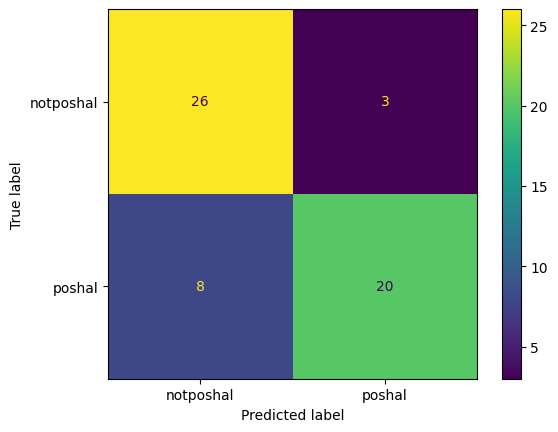

Accuracy: 0.8070175438596491


In [14]:
train_path  = "Desktop/poshal_train"
train_names = os.listdir(train_path)
train_pics = []
train_labels   = []
train_features = []
plot2 = []
for train_name in train_names:
   cur_path = train_path + "/" + train_name
   cur_label = train_name
   for file in glob.glob(cur_path + "/*.jpg"):
       img = cv2.imread(file)  
 
       img,heigth,width = preprocess(img) 
       yellow_pixels = yellow_mask(img)  
       gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                         
       _, binary_image = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
       skeleton = skeletonize(binary_image)
       length = cv2.countNonZero(skeleton) 
       branch_points = detect_branch_points(skeleton,heigth,width) 
       branch_points2 = detect_branch_points2(skeleton,heigth,width) 
       lines = get_lines(skeleton)
       destiny = get_destiny(lines)     
       khami = get_khami(lines) 
       feature = [branch_points2,yellow_pixels] 
       train_features.append( feature ) 
       train_labels.append(cur_label) 
        
arr = np.array(train_features)
min_max_scaler = p.MinMaxScaler()
train_features = min_max_scaler.fit_transform(arr)

test_features = []
test_pics = []
test_labels = []
test_pr = []

test_path = ("Desktop/poshal_test")
test_names = os.listdir(test_path)
for test_name in test_names:
   cur_path = test_path + "/" + test_name
   cur_label = test_name
   for file in glob.glob(cur_path + "/*.jpg"):
       img = cv2.imread(file) 
  
       img,heigth,width = preprocess(img) 
       yellow_pixels = yellow_mask(img)  
       gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       _, binary_image = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
       skeleton = skeletonize(binary_image)
       length = cv2.countNonZero(skeleton) 
       branch_points = detect_branch_points(skeleton,heigth,width) 
       branch_points2 = detect_branch_points2(skeleton,heigth,width) 
       lines = get_lines(skeleton)
       destiny = get_destiny(lines)     
       khami = get_khami(lines)
       feature = [branch_points2,yellow_pixels]  
       test_features.append( feature ) 
       test_labels.append(cur_label)  
    
arr = np.array(test_features)
min_max_scaler = p.MinMaxScaler()
test_features = min_max_scaler.fit_transform(arr)

model = SVC(C=100, kernel='rbf')
model.fit(train_features, train_labels)
prediction = model.predict(test_features)
confusion_matrix = metrics.confusion_matrix(test_labels, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['notposhal','poshal'])
cm_display.plot()
plt.show()
print("Accuracy:",metrics.accuracy_score(test_labels, prediction))

## best final model to classify to 'negin','poshal','negal'
### using just 'branch_points2' and 'yellow_pixels' give us the best score

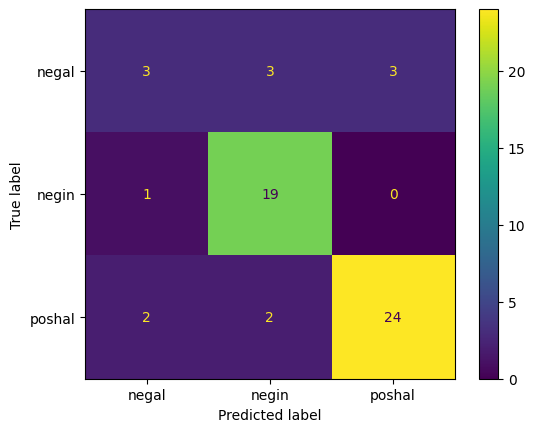

Accuracy: 0.8070175438596491


In [15]:
train_path  = "Desktop/train"
train_names = os.listdir(train_path)
train_pics = []
train_labels   = []
train_features = []
plot2 = []
for train_name in train_names:
   cur_path = train_path + "/" + train_name
   cur_label = train_name
   for file in glob.glob(cur_path + "/*.jpg"):
       img = cv2.imread(file)  
 
       img,heigth,width = preprocess(img) 
       yellow_pixels = yellow_mask(img)  
       gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                         
       _, binary_image = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
       skeleton = skeletonize(binary_image)
       branch_points2 = detect_branch_points2(skeleton,heigth,width) 
       feature = [branch_points2,yellow_pixels]
       train_features.append( feature ) 
       train_labels.append(cur_label) 
        
arr = np.array(train_features)
min_max_scaler = p.MinMaxScaler()
train_features = min_max_scaler.fit_transform(arr)

test_features = []
test_pics = []
test_labels = []
test_pr = []

test_path = ("Desktop/test")
test_names = os.listdir(test_path)
for test_name in test_names:
   cur_path = test_path + "/" + test_name
   cur_label = test_name
   for file in glob.glob(cur_path + "/*.jpg"):
       img = cv2.imread(file) 
  
       img,heigth,width = preprocess(img) 
       yellow_pixels = yellow_mask(img)  
       gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       _, binary_image = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
       skeleton = skeletonize(binary_image)
       branch_points2 = detect_branch_points2(skeleton,heigth,width) 
       feature = [branch_points2,yellow_pixels]  
       test_features.append( feature ) 
       test_labels.append(cur_label)  
    
arr = np.array(test_features)
min_max_scaler = p.MinMaxScaler()
test_features = min_max_scaler.fit_transform(arr)

# Create a SVM classifier
model = SVC(C=100, kernel='rbf')
model.fit(train_features, train_labels)
prediction = model.predict(test_features)
confusion_matrix = metrics.confusion_matrix(test_labels, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['negal','negin','poshal'])
cm_display.plot()
plt.show()
print("Accuracy:",metrics.accuracy_score(test_labels, prediction))